# Download en plot meest recente Harmonie data

Dit script downloadt de meest recente Harmonie dataset en plot de 10 meter wind op de laatste tijdstap van de data.

De data wordt opgeslagen op de locatie <u>/home/jovyan/work/private/HAR_mostrecent.nc</u>

Meer info:
<u>https://dataplatform.knmi.nl/dataset/preview/knmi-ha43-nl-2p5km-1-0</u>
<u>https://dataplatform.knmi.nl/dataset/access/knmi-ha43-nl-2p5km-1-0</u>

Vervang API key in tweede blok door anonymous API key in 
<u>https://developer.dataplatform.knmi.nl/open-data-api#token</u> als API key verlopen is

Op het eind van deze notebook staan instructies om de Harmonie data in Geoweb zichtbaar te maken!

In [107]:
import xarray as xr
import logging
import os
import sys
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd


Verwijder oude bestanden

In [108]:
rm '/home/jovyan/work/private/HAR_mostrecent.nc'

rm: cannot remove '/home/jovyan/work/private/HAR_mostrecent.nc': No such file or directory


In [110]:

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(os.environ.get("LOG_LEVEL", logging.INFO))


class OpenDataAPI:
    def __init__(self, api_token: str):
        self.base_url = "https://api.dataplatform.knmi.nl/open-data/v1"
        self.headers = {"Authorization": api_token}

    def __get_data(self, url, params=None):
        return requests.get(url, headers=self.headers, params=params).json()

    def list_files(self, dataset_name: str, dataset_version: str, params: dict):
        return self.__get_data(
            f"{self.base_url}/datasets/{dataset_name}/versions/{dataset_version}/files",
            params=params,
        )

    def get_file_url(self, dataset_name: str, dataset_version: str, file_name: str):
        return self.__get_data(
            f"{self.base_url}/datasets/{dataset_name}/versions/{dataset_version}/files/{file_name}/url"
        )


def download_file_from_temporary_download_url(download_url, filename):
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception:
        logger.exception("Unable to download file using download URL")
        sys.exit(1)

    logger.info(f"Successfully downloaded dataset file to {filename}")


def main():
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImE1OGI5NGZmMDY5NDRhZDNhZjFkMDBmNDBmNTQyNjBkIiwiaCI6Im11cm11cjEyOCJ9"
    dataset_name = "knmi_ha43_nl_2p5km"
    dataset_version = "1.0"
    filename_save = r'/home/jovyan/work/private/'
    logger.info(f"Fetching latest file of {dataset_name} version {dataset_version}")

    api = OpenDataAPI(api_token=api_key)

    # sort the files in descending order and only retrieve the first file
    params = {"maxKeys": 1, "orderBy": "created", "sorting": "desc"}
    response = api.list_files(dataset_name, dataset_version, params)
    if "error" in response:
        logger.error(f"Unable to retrieve list of files: {response['error']}")
        sys.exit(1)

    latest_file = response["files"][0].get("filename")
    logger.info(f"Latest file is: {latest_file}")

    # fetch the download url and download the file
    response = api.get_file_url(dataset_name, dataset_version, latest_file)
    download_file_from_temporary_download_url(response["temporaryDownloadUrl"], filename_save + 'HAR_mostrecent.nc')


if __name__ == "__main__":
    main()


INFO:__main__:Fetching latest file of knmi_ha43_nl_2p5km version 1.0
INFO:__main__:Latest file is: knmi_ha43_nl_2p5km_wind-speed-hagl_geoweb_nc_20240529T06.nc
INFO:__main__:Successfully downloaded dataset file to /home/jovyan/work/private/HAR_mostrecent.nc


In [111]:
testdata

<xarray.Dataset> Size: 365kB
Dimensions:                  (longitude: 300, latitude: 300)
Coordinates:
  * longitude                (longitude) float64 2kB 0.0 0.037 ... 11.03 11.06
  * latitude                 (latitude) float64 2kB 49.0 49.02 ... 55.85 55.88
    time                     datetime64[ns] 8B 2024-05-25T09:00:00
    wind_at_hagl             float64 8B 10.0
Data variables:
    forecast_reference_time  datetime64[ns] 8B ...
    latitude_longitude       int64 8B ...
    wind-speed-hagl          (latitude, longitude) float32 360kB 5.266 ... 7.932
Attributes:
    conventions:     CF-1.9
    title:           Arcus dataset
    institution:     KNMI
    source:          KNMI_HA43
    references:      
    comment:         
    time_fmt:        %Y-%m-%dT%H
    cycle_datetime:  2024-05-23T09

In [112]:
filename =  r'/home/jovyan/work/private/HAR_mostrecent.nc'

testdata = xr.open_dataset(filename)

timeOI = testdata.time[-1]

testdata = testdata.sel(time=timeOI, wind_at_hagl=10)


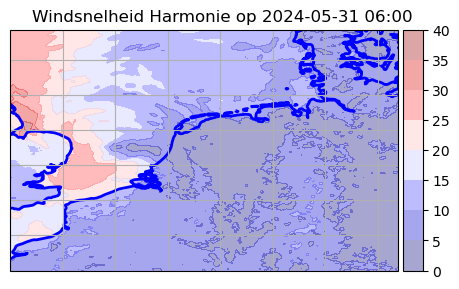

In [113]:
fig = plt.figure(figsize=[5,5])
proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)

CS = ax.contourf(testdata.longitude, testdata.latitude, testdata['wind-speed-hagl'], cmap = cm.seismic, alpha = 0.35, transform = ccrs.PlateCarree())  #divide by 10 is conversion to decameters

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

fig.colorbar(CS, cax=cax, orientation='vertical')

plt.title('Windsnelheid Harmonie op %s' % pd.to_datetime(timeOI.values).strftime('%Y-%m-%d %H:%M'), ha='right')

ax.coastlines(resolution='10m', color='blue', linewidth=2)
ax.gridlines()
plt.show()
#V = np.linspace(300,650,30)

Instructies zichtbaar maken Harmonie data in Geoweb

- Ga naar <u>http://swirrl-wow-vre.rdwd.dev.knmi.cloud/swirrl/adaguc/797a92c6-a1a3-4bf1-975c-ebc3b3d53669/adaguc-viewer/</u> (bij cannot GET / error --> plaats bericht in Slack kanaal eu-team dat adaguc server niet meer werkt. Zij kunnen dit snel oplossen.
- Ga naar autowms --> work --> private --> open Harmonie dataset
- Kopieer WMS link in browser + vervang '%2F' in '/' in URL
- Accepteer veligheidsrisico's
- Kopieer link en plak link in Geoweb (add layer --> plak URL in zoekbalk)
- Kaartje zou zichtbaar moeten zijn in Geoweb!